IMPLEMENTING THE PROJECT USING ANN


Author:Arvind K N


Work done for Infosys internship

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
# Load only Premier League CSVs (E0)
files = glob.glob("C:/Epl/data/E0*.csv")
print(files)
features=["Date","HomeTeam","AwayTeam","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]
target ="FTR"
dfs = []
for f in files:
    df = pd.read_csv(f, encoding='cp1252', on_bad_lines='skip')
    for col in features:
        if col not in df.columns:
         df[col] = pd.NA
    df = df[features + [target]]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
data["Date"] = pd.to_datetime(data["Date"], dayfirst=True, errors="coerce")
print("Shape:", data.shape)
print(data.head())


['C:/Epl/data\\E02000.csv', 'C:/Epl/data\\E02001.csv', 'C:/Epl/data\\E02002.csv', 'C:/Epl/data\\E02003.csv', 'C:/Epl/data\\E02004.csv', 'C:/Epl/data\\E02005.csv', 'C:/Epl/data\\E02006.csv', 'C:/Epl/data\\E02007.csv', 'C:/Epl/data\\E02008.csv', 'C:/Epl/data\\E02009.csv', 'C:/Epl/data\\E02010.csv', 'C:/Epl/data\\E02011.csv', 'C:/Epl/data\\E02012.csv', 'C:/Epl/data\\E02013.csv', 'C:/Epl/data\\E02014.csv', 'C:/Epl/data\\E02015.csv', 'C:/Epl/data\\E02016.csv', 'C:/Epl/data\\E02017.csv', 'C:/Epl/data\\E02018.csv', 'C:/Epl/data\\E02019.csv', 'C:/Epl/data\\E02020.csv', 'C:/Epl/data\\E02021.csv', 'C:/Epl/data\\E02022.csv', 'C:/Epl/data\\E02023.csv', 'C:/Epl/data\\E02024.csv']
Shape: (9411, 18)
        Date  HomeTeam       AwayTeam  HTHG  HTAG    HS    AS   HST  AST  \
0 2000-08-19  Charlton       Man City   2.0   0.0  17.0   8.0  14.0  4.0   
1 2000-08-19   Chelsea       West Ham   1.0   0.0  17.0  12.0  10.0  5.0   
2 2000-08-19  Coventry  Middlesbrough   1.0   1.0   6.0  16.0   3.0  9.0   
3 

C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\2351140533.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Date"] = pd.to_datetime(data["Date"], dayfirst=True, errors="coerce")


In [3]:
print(data.isnull().sum())
print((data.isnull().mean()*100).round(2))
data = data.drop(columns=["Date"])

Date        1
HomeTeam    1
AwayTeam    1
HTHG        1
HTAG        1
HS          1
AS          1
HST         1
AST         1
HF          1
AF          1
HC          1
AC          1
HY          1
AY          1
HR          1
AR          1
FTR         1
dtype: int64
Date        0.01
HomeTeam    0.01
AwayTeam    0.01
HTHG        0.01
HTAG        0.01
HS          0.01
AS          0.01
HST         0.01
AST         0.01
HF          0.01
AF          0.01
HC          0.01
AC          0.01
HY          0.01
AY          0.01
HR          0.01
AR          0.01
FTR         0.01
dtype: float64


In [4]:
data = data.dropna()
print("After dropping missing:",data.shape)
print("Remaining NaN:",data.isnull().sum().sum())

After dropping missing: (9410, 17)
Remaining NaN: 0


In [20]:
duplicates = data.duplicated().sum()
print("Number of duplicated rows:",duplicates)

Number of duplicated rows: 0


In [5]:

data['HT_goal_diff'] = data['HTHG'] - data['HTAG']
data['corner_diff'] = data['HC'] - data['AC']
data['home_shot_accuracy'] = data['HST'] / data['HS'].replace(0, 1)
data['away_shot_accuracy'] = data['AST'] / data['AS'].replace(0, 1)
data['cards_diff'] = ((data['HY'] + 2*data['HR']) -
                    (data['AY'] + 2*data['AR']))
data['fouls_diff'] = data['HF'] - data['AF']
data['shots_diff'] = data['HS'] - data['AS']
data['shots_on_target_diff'] = data['HST'] - data['AST']


In [25]:

print("Original shape:", data.shape)

# Identify the columns you need to one-hot encode
categorical_cols = ['HomeTeam', 'AwayTeam','FTR']

# Use pd.get_dummies to perform one-hot encoding
data_ohe = pd.get_dummies(data, columns=categorical_cols, drop_first=False)

# drop_first=True is used to avoid multicollinearity (the "dummy variable trap")
# It drops the first category from each feature.

print("Shape after one-hot encoding:", data_ohe.shape)
print(data_ohe.head())

# Now this 'data_ohe' DataFrame is what you would split into
# X and y, and then scale the numerical columns of X before
# feeding it to the ANN.

Original shape: (9410, 25)
Shape after one-hot encoding: (9410, 117)
   HTHG  HTAG    HS    AS   HST  AST    HF    AF   HC   AC  ...  \
0   2.0   0.0  17.0   8.0  14.0  4.0  13.0  12.0  6.0  6.0  ...   
1   1.0   0.0  17.0  12.0  10.0  5.0  19.0  14.0  7.0  7.0  ...   
2   1.0   1.0   6.0  16.0   3.0  9.0  15.0  21.0  8.0  4.0  ...   
3   1.0   2.0   6.0  13.0   4.0  6.0  11.0  13.0  5.0  8.0  ...   
4   2.0   0.0  17.0  12.0   8.0  6.0  21.0  20.0  6.0  4.0  ...   

   AwayTeam_Swansea  AwayTeam_Tottenham  AwayTeam_Watford  AwayTeam_West Brom  \
0             False               False             False               False   
1             False               False             False               False   
2             False               False             False               False   
3             False               False             False               False   
4             False               False             False               False   

   AwayTeam_West Ham  AwayTeam_Wigan  Awa

In [26]:
y_encoded = data_ohe[['FTR_D','FTR_H','FTR_A']]
X_ohe = data_ohe.drop(['FTR_D','FTR_H','FTR_A'],axis=1)

In [27]:

# 1. First, split your data into training and testing sets
# This is the most important step to do BEFORE scaling.
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_encoded,test_size=0.2, random_state=42,stratify=y_encoded) # stratify is good for imbalanced classes

print("Shape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)

# 2. Initialize the StandardScaler
scaler = StandardScaler()

# 3. Fit the scaler ONLY on the training data and transform it
# The scaler 'learns' the mean and standard deviation from the training data here.
X_train_scaled = scaler.fit_transform(X_train)

# 4. Use the ALREADY FITTED scaler to transform the test data
# This applies the same scaling rules learned from the training set to the test set.
X_test_scaled = scaler.transform(X_test)

# To make it easier to view, you can convert the scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nScaled training data (first 5 rows):")
print(X_train_scaled.head())

Shape of training data: (7528, 114)
Shape of testing data: (1882, 114)

Scaled training data (first 5 rows):
       HTHG      HTAG        HS        AS       HST       AST        HF  \
0 -0.826266 -0.702166 -0.107009 -1.023449 -0.289119 -0.612268  0.456957   
1 -0.826266  0.665822 -0.667858  2.151579 -1.215417  1.198367  1.526850   
2  0.368305 -0.702166 -0.480908  0.246562 -0.597885 -0.250141 -0.612936   
3  0.368305 -0.702166  0.079940 -1.235117 -0.289119 -0.612268 -0.077989   
4 -0.826266 -0.702166  1.762486 -1.023449 -0.289119 -1.336522 -0.880409   

         AF        HC        AC  ...  AwayTeam_Southampton  AwayTeam_Stoke  \
0  0.305603  0.634368 -0.654738  ...             -0.187626       -0.144034   
1 -1.218969 -1.297738 -0.654738  ...             -0.187626       -0.144034   
2  0.305603 -0.653703  0.072716  ...             -0.187626       -0.144034   
3  0.305603 -0.975721 -1.382192  ...             -0.187626       -0.144034   
4  0.051508  1.600421 -0.291011  ...             -

In [48]:
from sklearn.utils import class_weight
import numpy as np

# You need your y_train to be integer labels (0, 1, 2) for this calculation.
# Let's create it from your one-hot encoded labels.
y_train_integers = np.argmax(y_train.to_numpy(), axis=1)

# Calculate the class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)
class_weights_dict = dict(enumerate(class_weights))

print("Calculated Class Weights:", class_weights_dict)

Calculated Class Weights: {0: np.float64(1.353469974829198), 1: np.float64(0.7277648878576953), 2: np.float64(1.1272836178496557)}


In [53]:
from tensorflow import keras
from tensorflow.keras import layers
# Let's get the number of features from your scaled training data
input_shape = X_train_scaled.shape[1]

# Define the model using the Keras Sequential API
'''model = keras.Sequential([
    # Input Layer: It takes the shape of our input data (112 features).
    # 128 neurons is a good starting point. 'relu' is a standard activation function.
    layers.Dense(64, activation='relu', input_shape=[input_shape]),
    layers.Dropout(0.4),
    # Hidden Layer 1 with Dropout
    # Dropout randomly sets a fraction of input units to 0 at each update during training
    # time, which helps prevent overfitting. 0.4 means 40% of neurons will be dropped.
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    
    # Hidden Layer 2 with Dropout
    #layers.Dense(32, activation='relu'),
    #layers.Dropout(0.3),
    
    # Output Layer:
    # It has 3 neurons, one for each of your classes (H, D, A).
    # 'softmax' converts the outputs into a probability distribution for each class.
    layers.Dense(3, activation='softmax')
])'''
final_test_model = keras.Sequential([
    layers.Dense(3, activation='softmax', input_shape=[input_shape])
])

c:\Users\arnas\miniconda3\envs\ANN_project\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
from tensorflow.keras.optimizers import Adam

new_optimizer = Adam(learning_rate=0.00005)
model.compile(
    # Optimizer: 'adam' is a robust and widely-used default choice that works well.
    optimizer=new_optimizer,
    
    # Loss Function: As we discussed, 'categorical_crossentropy' is the perfect choice
    # because you one-hot encoded your target variable.
    loss='categorical_crossentropy',
    
    # Metrics: We want to monitor the 'accuracy' of the model during training.
    metrics=['accuracy']
)

# Finally, print a summary of the model you've just built!
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │         7,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,539 (37.26 KB)

 Trainable params: 9,539 (37.26 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Let's train the model for 50 epochs
# An epoch is one full pass through the entire training dataset.
# We'll use a batch size of 32, which is a good default.
# validation_split=0.2 will automatically set aside 20% of the training data
# to check the model's performance on unseen data at the end of each epoch.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Starting model training...")
history = model.fit(
    X_train_scaled,
    y_encoded, 
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    verbose=1 # This will show the live progress bar
)
print("Model training finished.")

Starting model training...
Epoch 1/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4686 - loss: 1.1052 - val_accuracy: 0.4668 - val_loss: 1.0675
Epoch 2/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4611 - loss: 1.1015 - val_accuracy: 0.4668 - val_loss: 1.0696
Epoch 3/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4611 - loss: 1.0995 - val_accuracy: 0.4661 - val_loss: 1.0716
Epoch 4/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4608 - loss: 1.0910 - val_accuracy: 0.4641 - val_loss: 1.0736
Epoch 5/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4520 - loss: 1.0902 - val_accuracy: 0.4622 - val_loss: 1.0753
Epoch 6/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4445 - loss: 1.0905 - val_accuracy: 0.4595 - val_loss: 1.0769
Epoch 7/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4492 - loss: 1.0898 - val_accuracy: 0.4575 - val_loss: 1.0782
Epoch 8/200
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.451

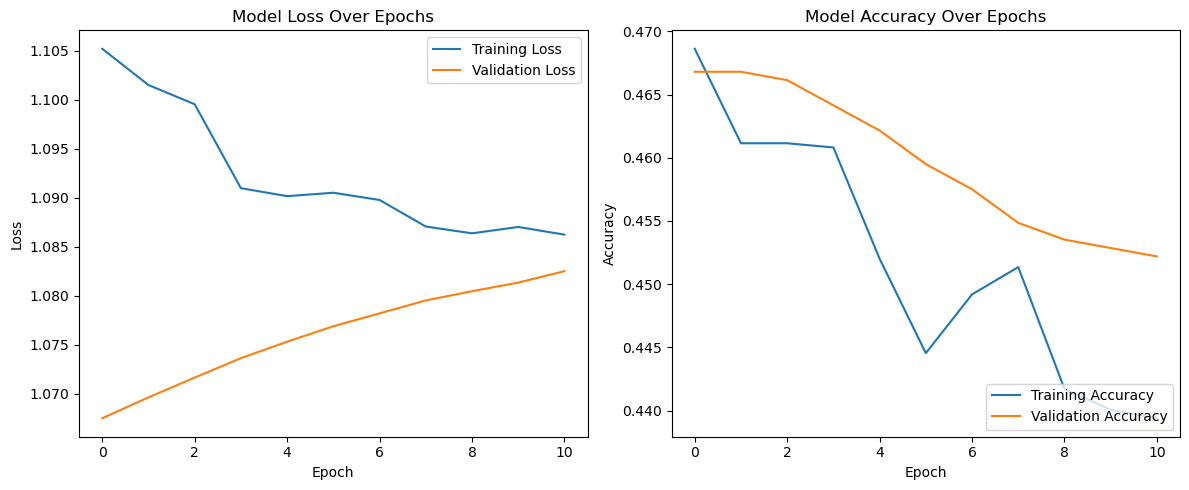

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the history object into a pandas DataFrame
history_df = pd.DataFrame(history.history)

# Plot the loss curves
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [57]:
# Evaluate the final model on the completely separate test set
print("\nEvaluating the final model on the test set...")
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)

print(f"\n-----------------------------------------")
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")
print(f"-----------------------------------------")


Evaluating the final model on the test set...
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4559 - loss: 1.0746

-----------------------------------------
Final Test Accuracy: 45.59%
-----------------------------------------


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.00      0.01       464
           1       0.46      0.99      0.63       862
           2       0.40      0.01      0.02       556

    accuracy                           0.46      1882
   macro avg       0.33      0.33      0.22      1882
weighted avg       0.36      0.46      0.30      1882



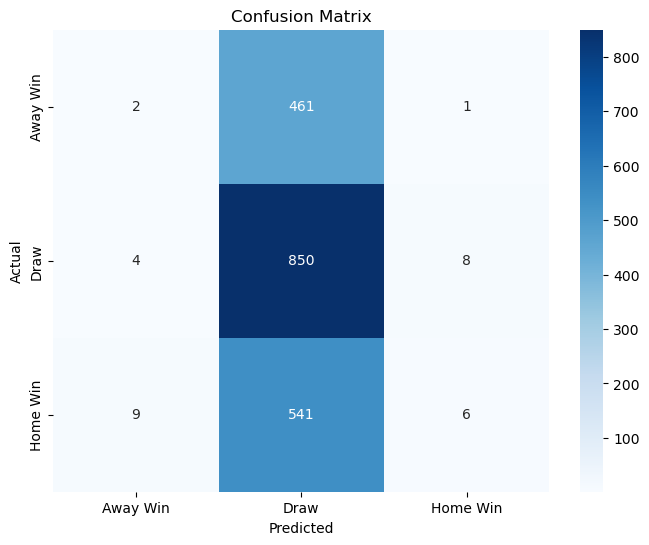

In [58]:
from sklearn.metrics import confusion_matrix, classification_report

# Assume 'best_model' is your final, trained model from the tuner
# Assume 'X_test_scaled' and 'y_test_encoded' are your test data

# Step 1: Get the raw probability predictions from the model
y_pred_probs = model.predict(X_test_scaled)

# Step 2: Convert the probabilities into single class predictions
# np.argmax finds the index (0, 1, or 2) with the highest probability for each sample.
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Step 3: Convert the one-hot encoded true labels back to single class labels
# (Make sure to use .to_numpy() if y_test_encoded is a pandas DataFrame)
y_true_labels = np.argmax(y_test.to_numpy(), axis=1)

# Step 4: Print the full classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))

# Step 5: Generate and plot the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
class_labels = ['Away Win', 'Draw', 'Home Win'] # Make sure this order is correct!

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [61]:
# merge_csvs_robust.py
import pandas as pd
import glob, os, csv, re, traceback

path = "C:/Epl/data/"           # <- change to your folder
pattern = "*.csv"          # or "*.txt" etc.
files = glob.glob(os.path.join(path, pattern))
print(f"Found {len(files)} files")

def detect_delimiter(fname, nbytes=4096):
    """Try to sniff the delimiter using csv.Sniffer, fallback to comma."""
    try:
        with open(fname, "r", encoding="utf-8", errors="replace") as f:
            sample = f.read(nbytes)
        return csv.Sniffer().sniff(sample).delimiter
    except Exception:
        return ","


def try_read(fname):
    """Try a few strategies to read a 'problem' CSV file."""
    encodings = ["utf-8", "latin1", "cp1252"]
    last_exc = None

    # 1) Fast try with default (C engine)
    for enc in encodings:
        try:
            return pd.read_csv(fname, encoding=enc, low_memory=False)
        except Exception as e:
            last_exc = e

    # 2) Detect delimiter and use python engine (more tolerant)
    delim = detect_delimiter(fname)
    for enc in encodings:
        try:
            return pd.read_csv(
                fname,
                encoding=enc,
                engine="python",      # python engine is more tolerant
                sep=delim,
                on_bad_lines="warn",  # "skip" will drop bad rows; "warn" shows warnings
                dtype=str,            # read everything as string to avoid dtype problems
            )
        except Exception as e:
            last_exc = e

    # 3) Try with QUOTE_NONE (if quotes are broken) — requires escapechar
    for enc in encodings:
        try:
            return pd.read_csv(
                fname,
                encoding=enc,
                engine="python",
                sep=delim,
                quoting=csv.QUOTE_NONE,
                escapechar="\\",
                on_bad_lines="warn",
                dtype=str,
            )
        except Exception as e:
            last_exc = e

    # If all fail, raise last exception so caller can log it
    raise last_exc


good_dfs = []
bad_files = []

for f in files:
    try:
        df = try_read(f)
        # Normalize column names a bit (strip whitespace)
        df.columns = [str(c).strip() for c in df.columns]
        good_dfs.append(df)
        print(f"OK: {os.path.basename(f)} rows={len(df)} cols={len(df.columns)}")
    except Exception as e:
        print(f"FAILED: {os.path.basename(f)} -> {type(e).__name__}: {e}")
        bad_files.append((f, str(e)))
        # Optional: show snippet around problem line if pandas gives a line number
        m = re.search(r'line (\d+)', str(e))
        if m:
            ln = int(m.group(1))
            try:
                with open(f, "r", encoding="utf-8", errors="replace") as fh:
                    lines = fh.readlines()
                start = max(0, ln-4)
                end = min(len(lines), ln+3)
                print(f"--- file snippet lines {start+1}:{end} ---")
                for i, L in enumerate(lines[start:end], start+start+1):
                    print(f"{i:6d}: {L.rstrip()}")
                print("--- end snippet ---")
            except Exception:
                pass

# Concatenate (union of columns). sort=False keeps original order as much as possible.
if good_dfs:
    merged = pd.concat(good_dfs, ignore_index=True, sort=False)
    print("Merged shape:", merged.shape)
    merged.to_csv("merged_dataset.csv", index=False)
    print("Saved merged_dataset.csv")
else:
    print("No good files to merge.")

# Save log of bad files
if bad_files:
    import json
    with open("bad_files_log.json", "w", encoding="utf-8") as fh:
        json.dump(bad_files, fh, indent=2, ensure_ascii=False)
    print(f"Logged {len(bad_files)} bad files to bad_files_log.json")



Found 25 files
OK: E02000.csv rows=380 cols=45
OK: E02001.csv rows=380 cols=48
OK: E02002.csv rows=380 cols=53
OK: E02003.csv rows=335 cols=57
OK: E02004.csv rows=335 cols=57
OK: E02005.csv rows=380 cols=68
OK: E02006.csv rows=380 cols=68
OK: E02007.csv rows=380 cols=71
OK: E02008.csv rows=380 cols=71
OK: E02009.csv rows=380 cols=71
OK: E02010.csv rows=380 cols=71
OK: E02011.csv rows=380 cols=71
OK: E02012.csv rows=380 cols=74
OK: E02013.csv rows=380 cols=68
OK: E02014.csv rows=381 cols=68
OK: E02015.csv rows=380 cols=65
OK: E02016.csv rows=380 cols=65
OK: E02017.csv rows=380 cols=65
OK: E02018.csv rows=380 cols=62
OK: E02019.csv rows=380 cols=106
OK: E02020.csv rows=380 cols=106
OK: E02021.csv rows=380 cols=106
OK: E02022.csv rows=380 cols=106
OK: E02023.csv rows=380 cols=106
OK: E02024.csv rows=380 cols=120


C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\3885424037.py:36: ParserWarning: Skipping line 305: Expected 57 fields in line 305, saw 72

  return pd.read_csv(
C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\3885424037.py:36: ParserWarning: Skipping line 306: Expected 57 fields in line 306, saw 72

  return pd.read_csv(
C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\3885424037.py:36: ParserWarning: Skipping line 307: Expected 57 fields in line 307, saw 72

  return pd.read_csv(
C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\3885424037.py:36: ParserWarning: Skipping line 308: Expected 57 fields in line 308, saw 72

  return pd.read_csv(
C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\3885424037.py:36: ParserWarning: Skipping line 309: Expected 57 fields in line 309, saw 72

  return pd.read_csv(
C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\3885424037.py:36: ParserWarning: Skipping line 310: Expected 57 fields in line 310, saw 72

  return pd.read_csv(
C:\Users\arnas\AppData

Merged shape: (9411, 192)
Saved merged_dataset.csv


In [1]:
import pandas as pd
import numpy as np

print("--- Initiating Unified Data Enrichment Protocol ---")

try:
    # --- 1. Load Data ---
    try:
        df = pd.read_csv("merged_dataset.csv", encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv("merged_dataset.csv", encoding='ISO-8859-1')
    print(f"Dataset loaded. Initial shape: {df.shape}")

    # --- 2. Initial Cleaning & Time-Series Prep ---
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df.dropna(subset=['Date', 'HomeTeam', 'AwayTeam', 'FTR'], inplace=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    print("Initial cleaning and date sorting complete.")

    # --- 3. Feature Engineering: Betting Odds (Consolidate & Impute) ---
    home_odds_cols = [col for col in ['B365H', 'WHH', 'LBH'] if col in df.columns]
    draw_odds_cols = [col for col in ['B365D', 'WHD', 'LBD'] if col in df.columns]
    away_odds_cols = [col for col in ['B365A', 'WHA', 'LBA'] if col in df.columns]

    df['Avg_Odds_H'] = df[home_odds_cols].mean(axis=1)
    df['Avg_Odds_D'] = df[draw_odds_cols].mean(axis=1)
    df['Avg_Odds_A'] = df[away_odds_cols].mean(axis=1)

    teams = pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()
    for team in teams:
        team_mask = (df['HomeTeam'] == team) | (df['AwayTeam'] == team)
        for col in ['Avg_Odds_H', 'Avg_Odds_D', 'Avg_Odds_A']:
              df.loc[team_mask, col] = df.loc[team_mask, col].fillna(df.loc[team_mask, col].rolling(10, min_periods=1).median())
    
    print("Betting odds features engineered.")
    
    # --- 4. Feature Engineering: Team Form --
    # --- MODIFIED AS PER YOUR REQUEST ---
    # Expanded this list to include all requested stats for the rolling average calculation.
    stats_cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG' ,'HS', 'AS', 'HF', 'AF', 'HC', 'AC', 'HST', 'AST', 'HY', 'AY', 'HR', 'AR']
    
    def get_rolling_stats(team, date, team_df):
        past_matches = team_df[team_df['Date'] < date].tail(5)
        if len(past_matches) < 5: return [np.nan] * len(stats_cols)
        return past_matches[stats_cols].mean().tolist()

    all_team_dfs = {team: pd.concat([df[df['HomeTeam'] == team], df[df['AwayTeam'] == team]]).sort_values(by='Date') for team in teams}
    
    form_features = []
    for index, row in df.iterrows():
        home_team, away_team, date = row['HomeTeam'], row['AwayTeam'], row['Date']
        home_stats = get_rolling_stats(home_team, date, all_team_dfs[home_team])
        away_stats = get_rolling_stats(away_team, date, all_team_dfs[away_team])
        form_features.append(home_stats + away_stats)

    form_feature_names = [f'H_form_{col}' for col in stats_cols] + [f'A_form_{col}' for col in stats_cols]
    form_df = pd.DataFrame(form_features, columns=form_feature_names, index=df.index)
    df = pd.concat([df, form_df], axis=1)
    print("Team form features engineered with expanded stats.")

    # --- 5. Feature Engineering: Head-to-Head (H2H) ---
    def get_h2h_stats(home_team, away_team, date):
        h2h_df = df[((df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)) | ((df['HomeTeam'] == away_team) & (df['AwayTeam'] == home_team))]
        past_h2h = h2h_df[h2h_df['Date'] < date]
        if len(past_h2h) == 0: return [0, 0, 0]
        hw = len(past_h2h[(past_h2h['HomeTeam'] == home_team) & (past_h2h['FTR'] == 'H')])
        aw = len(past_h2h[(past_h2h['AwayTeam'] == home_team) & (past_h2h['FTR'] == 'A')])
        home_wins = hw + aw
        draws = len(past_h2h[past_h2h['FTR'] == 'D'])
        total_games = len(past_h2h)
        return [(home_wins / total_games), ((total_games - home_wins - draws) / total_games), (draws / total_games)]

    h2h_features = []
    for index, row in df.iterrows():
        home_team, away_team, date = row['HomeTeam'], row['AwayTeam'], row['Date']
        h2h_stats = get_h2h_stats(home_team, away_team, date)
        h2h_features.append(h2h_stats)

    h2h_feature_names = ['H_H2H_win_pct', 'A_H2H_win_pct', 'H2H_draw_pct']
    h2h_df = pd.DataFrame(h2h_features, columns=h2h_feature_names, index=df.index)
    df = pd.concat([df, h2h_df], axis=1)
    print("H2H features engineered.")

    # --- Our Final Tactical Maneuver: Create "Difference" Features ---
    df['form_goal_diff'] = df['H_form_FTHG'] - df['A_form_FTHG']
    df['form_shot_target_diff'] = df['H_form_HST'] - df['A_form_HST']
    df['form_conceded_diff'] = df['H_form_FTAG'] - df['A_form_FTAG']

    # --- 6. Final Cleaning and Selection ---
    final_feature_cols = ['HomeTeam', 'AwayTeam', 'Avg_Odds_H', 'Avg_Odds_D', 'Avg_Odds_A','form_goal_diff','form_shot_target_diff','form_conceded_diff','HTHG','HTAG','HS','AS','AST','HST','HC','AC','HY','AY','HR','AR','HF','AF'] + form_feature_names + h2h_feature_names
    df_final = df[['Date', 'FTR'] + final_feature_cols].copy()
    
    df_final.dropna(inplace=True)
    df_final.reset_index(drop=True, inplace=True)
    
    output_path = "full_feature_dataset_expanded.csv"
    df_final.to_csv(output_path, index=False)

    print(f"\n--- Protocol Complete ---")
    print(f"Final dataset shape: {df_final.shape}")
    print(df_final.head())
    print(f"\nFully enriched dataset saved to '{output_path}'")

except Exception as e:
    print(f"An error occurred: {e}")

--- Initiating Unified Data Enrichment Protocol ---
Dataset loaded. Initial shape: (9411, 192)
Initial cleaning and date sorting complete.


C:\Users\arnas\AppData\Local\Temp\ipykernel_8564\1755154841.py:9: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("merged_dataset.csv", encoding='utf-8')
C:\Users\arnas\AppData\Local\Temp\ipykernel_8564\1755154841.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')


Betting odds features engineered.
Team form features engineered with expanded stats.
H2H features engineered.

--- Protocol Complete ---
Final dataset shape: (9232, 59)
        Date FTR     HomeTeam    AwayTeam  Avg_Odds_H  Avg_Odds_D  Avg_Odds_A  \
0 2000-09-16   H   Sunderland       Derby       1.760       3.325       3.875   
1 2000-09-16   A      Everton  Man United       4.315       3.250       1.700   
2 2000-09-16   H  Southampton   Newcastle       2.750       3.225       2.225   
3 2000-09-16   H      Arsenal    Coventry       1.250       4.415      10.250   
4 2000-09-16   H     Charlton   Tottenham       2.685       3.225       2.275   

   form_goal_diff  form_shot_target_diff  form_conceded_diff  ...  A_form_AC  \
0            -0.4                    0.6                -1.6  ...        6.4   
1            -0.6                   -1.4                 0.6  ...        3.4   
2             0.2                    0.2                 0.8  ...        4.6   
3             1.6       

In [62]:
import pandas as pd

try:
    # Using 'ISO-8859-1' encoding as a robust option for varied CSV files.
    df = pd.read_csv("merged_dataset.csv", encoding='ISO-8859-1')

    print("--- Diagnostics for merged_dataset.csv ---")
    
    print("\n--- First 5 Rows (Head) ---")
    print(df.head())

    print("\n--- DataFrame Info ---")
    df.info()

    print("\n--- Missing Values Count (Top 20) ---")
    print(df.isnull().sum().sort_values(ascending=False).head(20))

except FileNotFoundError:
    print("Error: Please ensure 'merged_dataset.csv' is in the same directory as this script.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Diagnostics for merged_dataset.csv ---

--- First 5 Rows (Head) ---
  Div      Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  ...  \
0  E0  19/08/00  Charlton       Man City   4.0   0.0   H   2.0   0.0   H  ...   
1  E0  19/08/00   Chelsea       West Ham   4.0   2.0   H   1.0   0.0   H  ...   
2  E0  19/08/00  Coventry  Middlesbrough   1.0   3.0   A   1.0   1.0   D  ...   
3  E0  19/08/00     Derby    Southampton   2.0   2.0   D   1.0   2.0   A  ...   
4  E0  19/08/00     Leeds        Everton   2.0   0.0   H   2.0   0.0   H  ...   

   1XBCH 1XBCD  1XBCA  BFECH  BFECD  BFECA  BFEC>2.5  BFEC<2.5  BFECAHH  \
0    NaN   NaN    NaN    NaN    NaN    NaN       NaN       NaN      NaN   
1    NaN   NaN    NaN    NaN    NaN    NaN       NaN       NaN      NaN   
2    NaN   NaN    NaN    NaN    NaN    NaN       NaN       NaN      NaN   
3    NaN   NaN    NaN    NaN    NaN    NaN       NaN       NaN      NaN   
4    NaN   NaN    NaN    NaN    NaN    NaN       NaN       NaN    

C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\4252452165.py:5: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("merged_dataset.csv", encoding='ISO-8859-1')


In [66]:
import pandas as pd

# Load the dataset
# Using a try-except block for robust encoding
try:
    df = pd.read_csv("merged_dataset.csv", encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv("merged_dataset.csv", encoding='ISO-8859-1')


print("Initial shape:", df.shape)

# --- 1. Data Cleaning Protocol ---
unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
df.drop(columns=unnamed_cols, inplace=True)

thresh = len(df) * 0.7
df.dropna(axis=1, thresh=thresh, inplace=True)

essential_cols = ['FTHG', 'FTAG', 'HS', 'AS', 'HC', 'AC', 'HomeTeam', 'AwayTeam', 'Date']
df.dropna(subset=essential_cols, inplace=True)

print("Shape after cleaning:", df.shape)

# --- 2. Preparing for Time-Series Analysis ---
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.dropna(subset=['Date'], inplace=True)

df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

print("Data sorted chronologically.")

# --- 3. Feature Engineering: Team Form (Corrected) ---
stats_cols = ['FTHG', 'FTAG', 'HS', 'AS', 'HC', 'AC']

def get_rolling_stats(team, date, team_df):
    past_matches = team_df[team_df['Date'] < date].tail(5)
    if len(past_matches) < 5:
        return [pd.NA] * len(stats_cols) # Use NA as a placeholder instead of 0
    return past_matches[stats_cols].mean().tolist()

all_teams = set(df['HomeTeam'].unique()) | set(df['AwayTeam'].unique())
all_team_dfs = {team: pd.concat([df[df['HomeTeam'] == team], df[df['AwayTeam'] == team]]).sort_values(by='Date') for team in all_teams}

form_features = []
for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    date = row['Date']
    
    home_stats = get_rolling_stats(home_team, date, all_team_dfs[home_team])
    away_stats = get_rolling_stats(away_team, date, all_team_dfs[away_team])
    
    form_features.append(home_stats + away_stats)
    
    if (index + 1) % 1000 == 0:
        print(f"Processed {index + 1}/{len(df)} matches for form features...")

print("Form feature calculation complete.")

form_feature_names = [f'H_form_{col}' for col in stats_cols] + [f'A_form_{col}' for col in stats_cols]
form_df = pd.DataFrame(form_features, columns=form_feature_names)

df_final = pd.concat([df.reset_index(drop=True), form_df.reset_index(drop=True)], axis=1)

# --- CORRECTED DROPPING LOGIC ---
# Now we drop only the rows where the form features are NA, which are the ones
# at the beginning of the dataset without enough historical data.
df_final.dropna(subset=form_feature_names, inplace=True)
df_final.reset_index(drop=True, inplace=True)


print("\n--- Final DataFrame with Form Features (Head) ---")
print(df_final.head())
print("\nFinal shape with new features:", df_final.shape)

# Save the processed data to a new CSV to use in the next steps
df_final.to_csv("enriched_dataset.csv", index=False)
print("\nEnriched dataset saved to 'enriched_dataset.csv'")

C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\3173801568.py:6: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("merged_dataset.csv", encoding='utf-8')
C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\3173801568.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')


Initial shape: (9411, 192)
Shape after cleaning: (9410, 41)
Data sorted chronologically.
Processed 1000/9410 matches for form features...
Processed 2000/9410 matches for form features...
Processed 3000/9410 matches for form features...
Processed 4000/9410 matches for form features...
Processed 5000/9410 matches for form features...
Processed 6000/9410 matches for form features...
Processed 7000/9410 matches for form features...
Processed 8000/9410 matches for form features...
Processed 9000/9410 matches for form features...
Form feature calculation complete.

--- Final DataFrame with Form Features (Head) ---
  Div       Date     HomeTeam    AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  E0 2000-09-16   Sunderland       Derby   2.0   1.0   H   1.0   0.0   H   
1  E0 2000-09-16      Everton  Man United   1.0   3.0   A   0.0   3.0   A   
2  E0 2000-09-16  Southampton   Newcastle   2.0   0.0   H   0.0   0.0   D   
3  E0 2000-09-16      Arsenal    Coventry   2.0   1.0   H   1.0   0.0   H   

In [67]:
import pandas as pd
import numpy as np

# Load the dataset
try:
    df = pd.read_csv("merged_dataset.csv", encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv("merged_dataset.csv", encoding='ISO-8859-1')

print("--- Data Loading and Cleaning ---")
# --- 1. Data Cleaning Protocol (as before) ---
unnamed_cols = [col for col in df.columns if 'Unnamed' in col]
df.drop(columns=unnamed_cols, inplace=True)
thresh = len(df) * 0.7
df.dropna(axis=1, thresh=thresh, inplace=True)
essential_cols = ['FTHG', 'FTAG', 'HS', 'AS', 'HC', 'AC', 'HomeTeam', 'AwayTeam', 'Date', 'FTR']
df.dropna(subset=essential_cols, inplace=True)

# --- 2. Time-Series Preparation (as before) ---
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

print("Cleaning and sorting complete. Starting feature engineering...")

# --- 3. Feature Engineering: Team Form (as before) ---
stats_cols = ['FTHG', 'FTAG', 'HS', 'AS', 'HC', 'AC']
def get_rolling_stats(team, date, team_df):
    past_matches = team_df[team_df['Date'] < date].tail(5)
    if len(past_matches) < 5: return [np.nan] * len(stats_cols)
    return past_matches[stats_cols].mean().tolist()

all_teams = set(df['HomeTeam'].unique()) | set(df['AwayTeam'].unique())
all_team_dfs = {team: pd.concat([df[df['HomeTeam'] == team], df[df['AwayTeam'] == team]]).sort_values(by='Date') for team in all_teams}

form_features = []
for index, row in df.iterrows():
    home_team, away_team, date = row['HomeTeam'], row['AwayTeam'], row['Date']
    home_stats = get_rolling_stats(home_team, date, all_team_dfs[home_team])
    away_stats = get_rolling_stats(away_team, date, all_team_dfs[away_team])
    form_features.append(home_stats + away_stats)
    if (index + 1) % 2000 == 0: print(f"Processed {index + 1}/{len(df)} matches for form features...")
print("Form feature calculation complete.")

form_feature_names = [f'H_form_{col}' for col in stats_cols] + [f'A_form_{col}' for col in stats_cols]
form_df = pd.DataFrame(form_features, columns=form_feature_names)
df_final = pd.concat([df, form_df], axis=1)

# --- 4. Feature Engineering: Head-to-Head (H2H) ---
def get_h2h_stats(home_team, away_team, date):
    h2h_df = df[((df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)) |
                ((df['HomeTeam'] == away_team) & (df['AwayTeam'] == home_team))]
    past_h2h = h2h_df[h2h_df['Date'] < date]
    
    if len(past_h2h) == 0:
        return [0, 0, 0] # No history, return neutral stats

    hw = len(past_h2h[(past_h2h['HomeTeam'] == home_team) & (past_h2h['FTR'] == 'H')])
    aw = len(past_h2h[(past_h2h['AwayTeam'] == home_team) & (past_h2h['FTR'] == 'A')])
    home_wins = hw + aw
    
    draws = len(past_h2h[past_h2h['FTR'] == 'D'])
    total_games = len(past_h2h)
    
    # Return win % for home team, win % for away team, draw %
    return [(home_wins / total_games), ((total_games - home_wins - draws) / total_games), (draws / total_games)]

h2h_features = []
for index, row in df_final.iterrows():
    home_team, away_team, date = row['HomeTeam'], row['AwayTeam'], row['Date']
    h2h_stats = get_h2h_stats(home_team, away_team, date)
    h2h_features.append(h2h_stats)
    if (index + 1) % 2000 == 0: print(f"Processed {index + 1}/{len(df_final)} matches for H2H features...")

print("H2H feature calculation complete.")

h2h_feature_names = ['H_H2H_win_pct', 'A_H2H_win_pct', 'H2H_draw_pct']
h2h_df = pd.DataFrame(h2h_features, columns=h2h_feature_names, index=df_final.index)
df_final = pd.concat([df_final, h2h_df], axis=1)

# --- 5. Final Cleaning ---
# Drop rows where form features could not be calculated
df_final.dropna(subset=form_feature_names, inplace=True)
df_final.reset_index(drop=True, inplace=True)

print("\n--- Final DataFrame with Form & H2H Features (Head) ---")
print(df_final.head())
print("\nFinal shape with all new features:", df_final.shape)

df_final.to_csv("final_enriched_dataset.csv", index=False)
print("\nFinal enriched dataset saved to 'final_enriched_dataset.csv'")

C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\4013632374.py:6: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("merged_dataset.csv", encoding='utf-8')
C:\Users\arnas\AppData\Local\Temp\ipykernel_7392\4013632374.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')


--- Data Loading and Cleaning ---
Cleaning and sorting complete. Starting feature engineering...
Processed 2000/9410 matches for form features...
Processed 4000/9410 matches for form features...
Processed 6000/9410 matches for form features...
Processed 8000/9410 matches for form features...
Form feature calculation complete.
Processed 2000/9410 matches for H2H features...
Processed 4000/9410 matches for H2H features...
Processed 6000/9410 matches for H2H features...
Processed 8000/9410 matches for H2H features...
H2H feature calculation complete.

--- Final DataFrame with Form & H2H Features (Head) ---
  Div       Date     HomeTeam    AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  E0 2000-09-16   Sunderland       Derby   2.0   1.0   H   1.0   0.0   H   
1  E0 2000-09-16      Everton  Man United   1.0   3.0   A   0.0   3.0   A   
2  E0 2000-09-16  Southampton   Newcastle   2.0   0.0   H   0.0   0.0   D   
3  E0 2000-09-16      Arsenal    Coventry   2.0   1.0   H   1.0   0.0   H   
4  E